# SNSB Data Analysis

In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
train = pd.read_csv('SNSB_1_figure_new.csv')
train.drop('고유번호', axis=1, inplace=True)
train.drop('CDR', axis=1, inplace=True)

In [6]:
print(train.shape)
train.head()

(2205, 10)


,Age,sex,edu_years,Rey_CFT_copy_score,Alternating_square_and_triangle,Luria_loop,K_MMSE_drawing,K_TMT_E_A_success,K_TMT_E_B_success,Sum_of_boxes
0,75,0,14.0,17,1,1,1,1,0,8.0
1,85,1,11.0,2,1,1,1,1,0,6.0
2,80,0,12.0,36,1,1,1,1,1,1.5
3,75,0,6.0,26,1,1,0,1,0,2.5
4,73,0,12.0,18,1,1,1,1,0,2.5


In [7]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#defining utility class
#by defining this, you only have to write "for loop" to load minibatch data
class DataLoader(object):
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

In [9]:
#defining MLP model
#generally out_dim is more than 1, but this model only allows 1.
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.out_dim)
    
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = x.squeeze(1)
        return x

In [10]:
#data formatting
y = train.Sum_of_boxes
x = train.drop(['Sum_of_boxes'], axis=1)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.4)

# pd.DataFrame to np.ndarray
x_train = x_train.values
y_train = y_train.values
x_valid = x_valid.values
y_valid = y_valid.values
assert isinstance(x_train, np.ndarray)

In [15]:
#instantiate model
mlp = MLP(x_train.shape[1], 200, 1).to(device)
optimizer = optim.Adam(mlp.parameters())
train_dataloader = DataLoader(x_train, y_train, batch_size=256)
valid_dataloader = DataLoader(x_valid, y_valid, batch_size=256)

In [16]:
#this model learns to minimize MAE
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [17]:
#training phase
epochs = 1000
#to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_dataloader.data_size // train_dataloader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(train_dataloader):
        
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = valid_dataloader.data_size // valid_dataloader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(valid_dataloader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:5/6 Loss:3.0115 Time:0m0.01s
Valid Loss:2.5208
Epoch:2 Batch:5/6 Loss:3.0848 Time:0m0.01s
Valid Loss:2.4328
Epoch:3 Batch:5/6 Loss:1.6239 Time:0m0.01s
Valid Loss:2.3990
Epoch:4 Batch:5/6 Loss:2.4345 Time:0m0.01s
Valid Loss:2.3797
Epoch:5 Batch:5/6 Loss:2.2774 Time:0m0.01s
Valid Loss:2.3586
Epoch:6 Batch:5/6 Loss:2.6809 Time:0m0.01s
Valid Loss:2.4034
Epoch:7 Batch:5/6 Loss:2.0277 Time:0m0.01s
Valid Loss:2.3314
Epoch:8 Batch:5/6 Loss:2.3528 Time:0m0.01s
Valid Loss:2.3446
Epoch:9 Batch:5/6 Loss:2.6082 Time:0m0.01s
Valid Loss:2.3659
Epoch:10 Batch:5/6 Loss:2.5959 Time:0m0.01s
Valid Loss:2.3442
Epoch:11 Batch:5/6 Loss:2.3512 Time:0m0.01s
Valid Loss:2.3433
Epoch:12 Batch:5/6 Loss:2.4908 Time:0m0.01s
Valid Loss:2.3674
Epoch:13 Batch:5/6 Loss:2.2115 Time:0m0.01s
Valid Loss:2.3830
Epoch:14 Batch:5/6 Loss:2.1065 Time:0m0.01s
Valid Loss:2.3713
Epoch:15 Batch:5/6 Loss:2.6530 Time:0m0.01s
Valid Loss:2.3693
Epoch:16 Batch:5/6 Loss:2.5248 Time:0m0.01s
Valid Loss:2.3126
Epoch:17 Batch:5/

Epoch:134 Batch:5/6 Loss:2.7559 Time:0m0.01s
Valid Loss:2.3361
Epoch:135 Batch:5/6 Loss:2.3955 Time:0m0.01s
Valid Loss:2.4024
Epoch:136 Batch:5/6 Loss:2.4652 Time:0m0.01s
Valid Loss:2.3318
Epoch:137 Batch:5/6 Loss:2.1513 Time:0m0.01s
Valid Loss:2.3568
Epoch:138 Batch:5/6 Loss:2.2327 Time:0m0.01s
Valid Loss:2.3124
Epoch:139 Batch:5/6 Loss:2.3606 Time:0m0.01s
Valid Loss:2.3714
Epoch:140 Batch:5/6 Loss:2.7211 Time:0m0.01s
Valid Loss:2.3397
Epoch:141 Batch:5/6 Loss:2.3257 Time:0m0.01s
Valid Loss:2.3635
Epoch:142 Batch:5/6 Loss:1.9187 Time:0m0.01s
Valid Loss:2.3337
Epoch:143 Batch:5/6 Loss:2.4768 Time:0m0.01s
Valid Loss:2.3878
Epoch:144 Batch:5/6 Loss:2.1396 Time:0m0.01s
Valid Loss:2.3550
Epoch:145 Batch:5/6 Loss:2.5931 Time:0m0.01s
Valid Loss:2.3227
Epoch:146 Batch:5/6 Loss:2.3606 Time:0m0.01s
Valid Loss:2.3349
Epoch:147 Batch:5/6 Loss:2.9536 Time:0m0.01s
Valid Loss:2.3574
Epoch:148 Batch:5/6 Loss:1.9071 Time:0m0.01s
Valid Loss:2.3428
Epoch:149 Batch:5/6 Loss:2.8489 Time:0m0.01s
Valid Loss

Epoch:269 Batch:5/6 Loss:2.4652 Time:0m0.01s
Valid Loss:2.3591
Epoch:270 Batch:5/6 Loss:2.4303 Time:0m0.01s
Valid Loss:2.3792
Epoch:271 Batch:5/6 Loss:2.1861 Time:0m0.01s
Valid Loss:2.3810
Epoch:272 Batch:5/6 Loss:2.6396 Time:0m0.01s
Valid Loss:2.3926
Epoch:273 Batch:5/6 Loss:2.3838 Time:0m0.01s
Valid Loss:2.3628
Epoch:274 Batch:5/6 Loss:2.3838 Time:0m0.01s
Valid Loss:2.3579
Epoch:275 Batch:5/6 Loss:2.5698 Time:0m0.01s
Valid Loss:2.3403
Epoch:276 Batch:5/6 Loss:2.5349 Time:0m0.01s
Valid Loss:2.3829
Epoch:277 Batch:5/6 Loss:1.8372 Time:0m0.01s
Valid Loss:2.4096
Epoch:278 Batch:5/6 Loss:3.1047 Time:0m0.01s
Valid Loss:2.3658
Epoch:279 Batch:5/6 Loss:3.0466 Time:0m0.01s
Valid Loss:2.3622
Epoch:280 Batch:5/6 Loss:2.5465 Time:0m0.01s
Valid Loss:2.3500
Epoch:281 Batch:5/6 Loss:2.2791 Time:0m0.01s
Valid Loss:2.3835
Epoch:282 Batch:5/6 Loss:1.9884 Time:0m0.01s
Valid Loss:2.3768
Epoch:283 Batch:5/6 Loss:2.8024 Time:0m0.01s
Valid Loss:2.4504
Epoch:284 Batch:5/6 Loss:1.9768 Time:0m0.01s
Valid Loss

Epoch:402 Batch:5/6 Loss:2.4186 Time:0m0.01s
Valid Loss:2.3689
Epoch:403 Batch:5/6 Loss:2.6744 Time:0m0.01s
Valid Loss:2.3914
Epoch:404 Batch:5/6 Loss:2.0000 Time:0m0.01s
Valid Loss:2.3920
Epoch:405 Batch:5/6 Loss:2.5233 Time:0m0.01s
Valid Loss:2.3658
Epoch:406 Batch:5/6 Loss:2.2326 Time:0m0.01s
Valid Loss:2.3834
Epoch:407 Batch:5/6 Loss:2.6744 Time:0m0.01s
Valid Loss:2.3816
Epoch:408 Batch:5/6 Loss:2.4419 Time:0m0.01s
Valid Loss:2.3506
Epoch:409 Batch:5/6 Loss:2.2558 Time:0m0.01s
Valid Loss:2.3451
Epoch:410 Batch:5/6 Loss:2.6279 Time:0m0.01s
Valid Loss:2.3798
Epoch:411 Batch:5/6 Loss:2.1861 Time:0m0.01s
Valid Loss:2.3543
Epoch:412 Batch:5/6 Loss:2.6279 Time:0m0.01s
Valid Loss:2.3907
Epoch:413 Batch:5/6 Loss:2.2442 Time:0m0.01s
Valid Loss:2.3555
Epoch:414 Batch:5/6 Loss:2.0116 Time:0m0.01s
Valid Loss:2.3488
Epoch:415 Batch:5/6 Loss:2.6744 Time:0m0.01s
Valid Loss:2.3518
Epoch:416 Batch:5/6 Loss:2.3140 Time:0m0.01s
Valid Loss:2.3476
Epoch:417 Batch:5/6 Loss:2.5814 Time:0m0.01s
Valid Loss

Epoch:534 Batch:5/6 Loss:2.6395 Time:0m0.01s
Valid Loss:2.3500
Epoch:535 Batch:5/6 Loss:2.6512 Time:0m0.01s
Valid Loss:2.3542
Epoch:536 Batch:5/6 Loss:2.9884 Time:0m0.01s
Valid Loss:2.3171
Epoch:537 Batch:5/6 Loss:2.0233 Time:0m0.01s
Valid Loss:2.4169
Epoch:538 Batch:5/6 Loss:2.9419 Time:0m0.01s
Valid Loss:2.3488
Epoch:539 Batch:5/6 Loss:2.3605 Time:0m0.01s
Valid Loss:2.3883
Epoch:540 Batch:5/6 Loss:2.7675 Time:0m0.01s
Valid Loss:2.3840
Epoch:541 Batch:5/6 Loss:2.4535 Time:0m0.01s
Valid Loss:2.3445
Epoch:542 Batch:5/6 Loss:1.8837 Time:0m0.01s
Valid Loss:2.3494
Epoch:543 Batch:5/6 Loss:2.3954 Time:0m0.01s
Valid Loss:2.3062
Epoch:544 Batch:5/6 Loss:1.9535 Time:0m0.01s
Valid Loss:2.3737
Epoch:545 Batch:5/6 Loss:2.5465 Time:0m0.01s
Valid Loss:2.3749
Epoch:546 Batch:5/6 Loss:2.3721 Time:0m0.01s
Valid Loss:2.3999
Epoch:547 Batch:5/6 Loss:1.9419 Time:0m0.01s
Valid Loss:2.3561
Epoch:548 Batch:5/6 Loss:2.2675 Time:0m0.01s
Valid Loss:2.3761
Epoch:549 Batch:5/6 Loss:1.9302 Time:0m0.01s
Valid Loss

Epoch:667 Batch:5/6 Loss:2.0581 Time:0m0.01s
Valid Loss:2.3828
Epoch:668 Batch:5/6 Loss:1.9186 Time:0m0.01s
Valid Loss:2.3287
Epoch:669 Batch:5/6 Loss:2.6279 Time:0m0.01s
Valid Loss:2.4102
Epoch:670 Batch:5/6 Loss:2.6628 Time:0m0.01s
Valid Loss:2.4102
Epoch:671 Batch:5/6 Loss:2.2907 Time:0m0.01s
Valid Loss:2.3561
Epoch:672 Batch:5/6 Loss:2.4535 Time:0m0.01s
Valid Loss:2.3561
Epoch:673 Batch:5/6 Loss:2.1512 Time:0m0.01s
Valid Loss:2.4011
Epoch:674 Batch:5/6 Loss:2.5698 Time:0m0.01s
Valid Loss:2.3190
Epoch:675 Batch:5/6 Loss:1.9302 Time:0m0.01s
Valid Loss:2.3275
Epoch:676 Batch:5/6 Loss:2.0814 Time:0m0.01s
Valid Loss:2.3774
Epoch:677 Batch:5/6 Loss:2.4651 Time:0m0.01s
Valid Loss:2.3701
Epoch:678 Batch:5/6 Loss:2.1279 Time:0m0.01s
Valid Loss:2.3451
Epoch:679 Batch:5/6 Loss:1.8140 Time:0m0.01s
Valid Loss:2.3992
Epoch:680 Batch:5/6 Loss:2.4651 Time:0m0.01s
Valid Loss:2.3652
Epoch:681 Batch:5/6 Loss:3.1977 Time:0m0.01s
Valid Loss:2.3719
Epoch:682 Batch:5/6 Loss:2.8023 Time:0m0.01s
Valid Loss

Epoch:803 Batch:5/6 Loss:2.2326 Time:0m0.01s
Valid Loss:2.3585
Epoch:804 Batch:5/6 Loss:2.1047 Time:0m0.01s
Valid Loss:2.3579
Epoch:805 Batch:5/6 Loss:2.4070 Time:0m0.01s
Valid Loss:2.3944
Epoch:806 Batch:5/6 Loss:2.7209 Time:0m0.01s
Valid Loss:2.3275
Epoch:807 Batch:5/6 Loss:2.3256 Time:0m0.01s
Valid Loss:2.3761
Epoch:808 Batch:5/6 Loss:1.9419 Time:0m0.01s
Valid Loss:2.3257
Epoch:809 Batch:5/6 Loss:2.0000 Time:0m0.01s
Valid Loss:2.4059
Epoch:810 Batch:5/6 Loss:2.7093 Time:0m0.01s
Valid Loss:2.3859
Epoch:811 Batch:5/6 Loss:2.6744 Time:0m0.01s
Valid Loss:2.3506
Epoch:812 Batch:5/6 Loss:1.9186 Time:0m0.01s
Valid Loss:2.3506
Epoch:813 Batch:5/6 Loss:2.4651 Time:0m0.01s
Valid Loss:2.3932
Epoch:814 Batch:5/6 Loss:2.0698 Time:0m0.01s
Valid Loss:2.3658
Epoch:815 Batch:5/6 Loss:1.8721 Time:0m0.01s
Valid Loss:2.3603
Epoch:816 Batch:5/6 Loss:2.4302 Time:0m0.01s
Valid Loss:2.3658
Epoch:817 Batch:5/6 Loss:2.8837 Time:0m0.01s
Valid Loss:2.3506
Epoch:818 Batch:5/6 Loss:1.9767 Time:0m0.01s
Valid Loss

Epoch:937 Batch:5/6 Loss:2.0581 Time:0m0.01s
Valid Loss:2.3518
Epoch:938 Batch:5/6 Loss:2.0581 Time:0m0.01s
Valid Loss:2.3244
Epoch:939 Batch:5/6 Loss:2.3488 Time:0m0.01s
Valid Loss:2.3694
Epoch:940 Batch:5/6 Loss:2.5581 Time:0m0.01s
Valid Loss:2.3883
Epoch:941 Batch:5/6 Loss:2.4767 Time:0m0.01s
Valid Loss:2.3731
Epoch:942 Batch:5/6 Loss:2.3721 Time:0m0.01s
Valid Loss:2.3597
Epoch:943 Batch:5/6 Loss:3.0814 Time:0m0.01s
Valid Loss:2.3293
Epoch:944 Batch:5/6 Loss:2.6860 Time:0m0.01s
Valid Loss:2.3828
Epoch:945 Batch:5/6 Loss:3.1279 Time:0m0.01s
Valid Loss:2.3944
Epoch:946 Batch:5/6 Loss:2.0233 Time:0m0.01s
Valid Loss:2.3621
Epoch:947 Batch:5/6 Loss:1.8605 Time:0m0.01s
Valid Loss:2.3749
Epoch:948 Batch:5/6 Loss:1.8256 Time:0m0.01s
Valid Loss:2.4382
Epoch:949 Batch:5/6 Loss:2.9535 Time:0m0.01s
Valid Loss:2.3646
Epoch:950 Batch:5/6 Loss:2.4186 Time:0m0.01s
Valid Loss:2.3944
Epoch:951 Batch:5/6 Loss:2.4535 Time:0m0.01s
Valid Loss:2.3548
Epoch:952 Batch:5/6 Loss:2.4884 Time:0m0.01s
Valid Loss

minimum validation loss is 2.2904


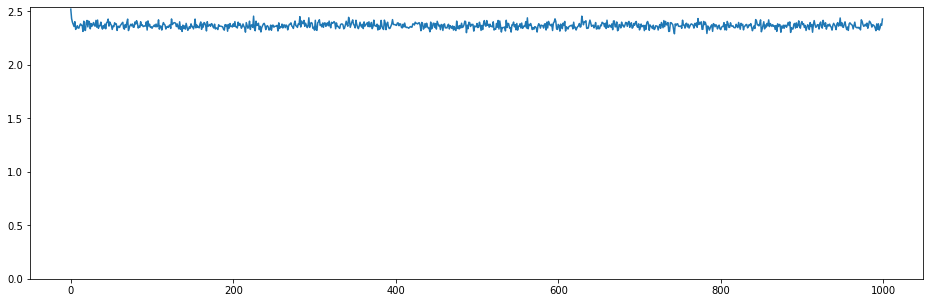

In [18]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.ylim(0,max(valid_losses)+0.02)
plt.plot(valid_losses)
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))